<a href="https://colab.research.google.com/github/GrabowMar/NNproject/blob/main/Projekt_Sieci_Neuronowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Klasyfikacja Pochodzenia Etnicznego na Podstawie Zdjęć Twarzy z Wykorzystaniem Sieci Neuronowych**

## **Podsumowanie**  
Projekt analizuje skuteczność różnych architektur CNN w klasyfikacji pochodzenia etnicznego na podstawie zdjęć twarzy. Przeprowadzono eksperymenty z kilkoma modelami, oceniając ich dokładność, stratę oraz czas trenowania. Zastosowano odpowiednie techniki przetwarzania i augmentacji danych, aby zwiększyć skuteczność klasyfikacji.

## **Dane wejściowe**  

- **Liczba próbek:** 23 705  
- **Wymiary obrazów:** 48x48 pikseli  
- **Podział danych:**  
  - Zbiór treningowy: 14 223 próbek  
  - Zbiór walidacyjny: 4 741 próbek  
  - Zbiór testowy: 4 741 próbek  

**Zakres wartości zmiennych:**  

| Cecha      | Min | Max | Średnia | Odchylenie std. |
|------------|-----|-----|---------|----------------|
| Wiek       | 1   | 116 | 33.3     | 19.88           |
| Pochodzenie| 0   | 4   | 1.27     | 1.34            |
| Płeć       | 0   | 1   | 0.47     | 0.49            |


## **Proces trenowania**  

**Techniki przetwarzania danych:**  
- Skalowanie obrazów  
- Normalizacja wartości pikseli  
- Augmentacja (rotacja, odbicia, zmiana kontrastu)  

**Metody oceny modeli:**  
- Dokładność (accuracy)  
- Funkcja straty (loss)  
- Krzywe walidacyjne  



## 2. Konfiguracja

### 2.1 Importy i ustawienia środowiska wykonawczego

In [1]:
# Core data processing libraries
import os
import random
from pathlib import Path
import zipfile
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, List, Tuple
import sys 

# Scientific computing and data analysis
import numpy as np
import pandas as pd

# Machine learning and deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Verify TensorFlow GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

TensorFlow version: 2.18.0
GPU Available:  []


### 2.2 Pobranie i przygotowanie danych

In [2]:
class DataLoader:
    def __init__(self, is_colab=False, base_dir="data"):
        self.is_colab = is_colab

        if is_colab:
                # Mount Google Drive
                from google.colab import drive
                drive.mount('/content/drive')
                
                # Set Kaggle credentials path
                import os
                os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
                
                # Initialize paths (this was missing)
                self.kaggle_dir = Path('/content/drive/MyDrive/kaggle')
                self.dataset_zip = self.kaggle_dir / "age-gender-and-ethnicity-face-data-csv.zip"
                self.csv_path = self.kaggle_dir / "age_gender.csv"

                # Download dataset if not exists
                import zipfile
                kaggle_path = '/content/drive/MyDrive/kaggle'
                zip_path = f'{kaggle_path}/age-gender-and-ethnicity-face-data-csv.zip'
                
                if not os.path.exists(zip_path):
                    !kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv -p {kaggle_path}
                    
                # Extract zip file
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(kaggle_path)
                    
                # Read data from extracted CSV
                data = pd.read_csv(f'{kaggle_path}/age_gender.csv')
                
        else:
            # Initialize paths
            self.data_dir = Path(base_dir)
            self.kaggle_dir = self.data_dir / "kaggle"
            self.dataset_zip = self.kaggle_dir / "age-gender-and-ethnicity-face-data-csv.zip"
            self.csv_path = self.kaggle_dir / "age_gender.csv"

    def _setup_kaggle_credentials(self):
        kaggle_json = Path.home() / ".kaggle" / "kaggle.json"
        if not kaggle_json.exists():
            raise FileNotFoundError("Kaggle credentials not found at ~/.kaggle/kaggle.json")
        kaggle_json.chmod(0o600)
        os.environ['KAGGLE_CONFIG_DIR'] = str(kaggle_json.parent)

    def _download_dataset(self):
        print("Downloading dataset...")
        download_cmd = f'kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv -p {self.dataset_zip.parent}'
        result = os.system(download_cmd)
        if result != 0:
            raise RuntimeError("Failed to download dataset from Kaggle")

    def _extract_dataset(self):
        print("Extracting dataset...")
        try:
            with zipfile.ZipFile(self.dataset_zip, 'r') as zip_ref:
                zip_ref.extractall(self.dataset_zip.parent)
        except zipfile.BadZipFile:
            raise ValueError("Corrupt zip file detected")

    def load_dataset(self):
        """Download (if needed), extract, and load the dataset."""
        try:
            if not self.dataset_zip.exists():
                self._download_dataset()
            
            if not self.csv_path.exists():
                self._extract_dataset()

            data = pd.read_csv(self.csv_path)
            print(f"Loaded dataset: {data.shape[0]} rows, {data.shape[1]} columns")
            return data

        except Exception as e:
            raise RuntimeError(f"Failed to load dataset: {str(e)}")

def load_data(is_colab=False, base_dir="data"):
    """Helper function to load the dataset."""
    try:
        loader = DataLoader(is_colab=is_colab, base_dir=base_dir)
        return loader.load_dataset()
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

def main():
    """Load the age-gender dataset."""
    try:
        loader = DataLoader()
        return loader.load_dataset()
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

if __name__ == "__main__":
    data = main()

Loaded dataset: 23705 rows, 5 columns


In [3]:
# Display basic dataset information
print(f"Dataset shape: {data.shape[0]:,} rows × {data.shape[1]} columns")
print("\nColumns:", ", ".join(data.columns))

# Show data types and memory usage
print("\nDataset info:")
data.info(show_counts=True)

# Display value ranges for key columns
print("\nValue ranges:")
numeric_summary = data.describe()
print(numeric_summary)

# Show a few example rows
print("\nFirst few rows:")
display(data.head())  # Using display() for nicer notebook output

Dataset shape: 23,705 rows × 5 columns

Columns: age, ethnicity, gender, img_name, pixels

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB

Value ranges:
                age     ethnicity        gender
count  23705.000000  23705.000000  23705.000000
mean      33.300907      1.269226      0.477283
std       19.885708      1.345638      0.499494
min        1.000000      0.000000      0.000000
25%       23.000000      0.000000      0.000000
50%       29.000000      1.000000      0.000000
75%       45.000000      2.000000      1.000000
max      116.000000      4.000000      1.000000

First few rows

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


### 2.3 Podział na wartości cech i zmiennych docelowych

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in the dataset:\n", missing_values)

# Separate features and target
x = data[["pixels"]].copy()
y = data[["ethnicity"]].copy()

# Free up memory
del data

# Calculate image dimensions
num_pixels = len(x["pixels"][0].split(" "))
img_height = img_width = int(np.sqrt(num_pixels))
print(f"Image dimensions: {img_height}x{img_width}")

# Convert pixel strings to normalized arrays
x = x["pixels"].apply(lambda pixel_string: np.array(list(map(int, pixel_string.split()))))
x = np.stack(x.values, axis=0).reshape(-1, img_height, img_width, 1)
x = x / 255.0

print("Processed feature data shape:", x.shape)

Missing values in the dataset:
 age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64
Image dimensions: 48x48
Processed feature data shape: (23705, 48, 48, 1)


### 3.1 Wizualizacja danych

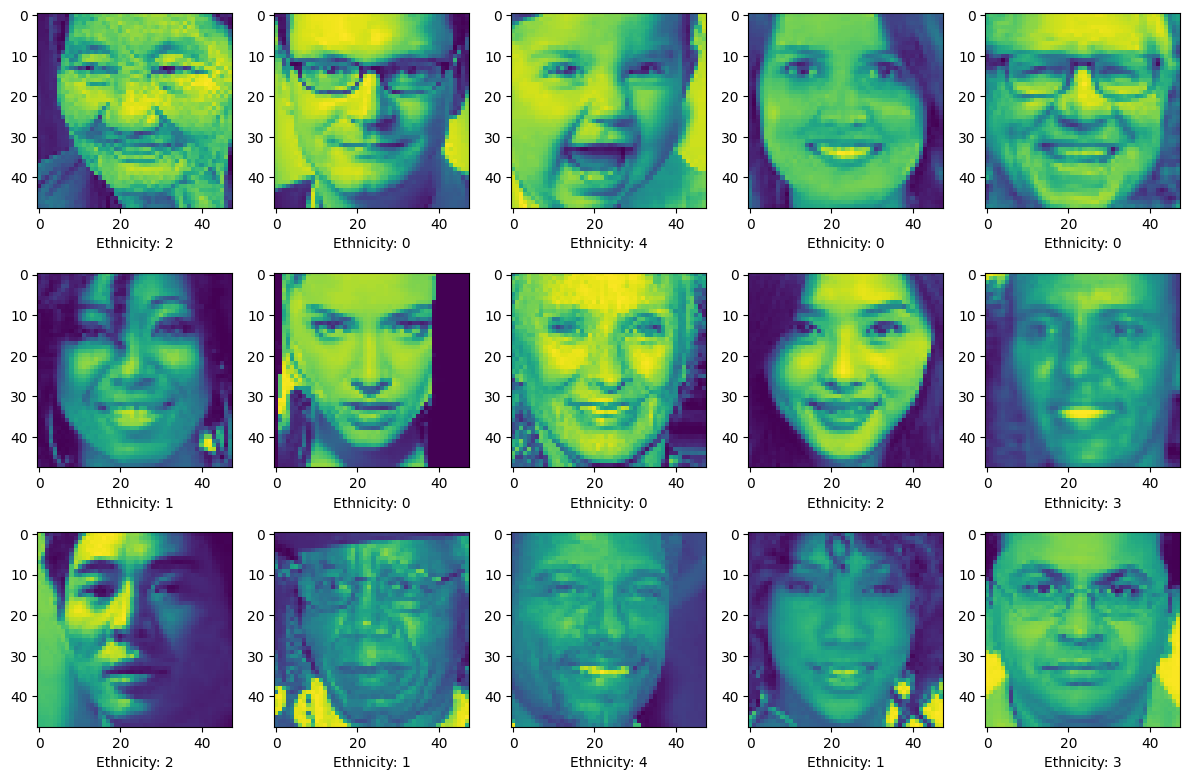

In [5]:
# Your original visualization code
plt.figure(figsize=(12, 8))
random_indices = np.random.randint(0, x.shape[0], 16)

for i, subplot_index in zip(random_indices, range(1, 16)):
    plt.subplot(3, 5, subplot_index)
    plt.imshow(x[i].squeeze())
    plt.xlabel(f"Ethnicity: {y['ethnicity'].iloc[i]}")

plt.tight_layout()
plt.show()

## 4. Podział na zbiory uczące i walidacyjny

In [6]:
# Display the distribution
ethnicity_matrix = np.array(y["ethnicity"])
ethnicity_labels = to_categorical(ethnicity_matrix, num_classes=5)

x_train, x_temp, ethnicity_train, ethnicity_temp = train_test_split(
    x, ethnicity_labels, test_size=0.4, random_state=42
)

x_val, x_test, ethnicity_val, ethnicity_test = train_test_split(
    x_temp, ethnicity_temp, test_size=0.5, random_state=42
)

print("Dataset splits:")
print(f"Training set: {x_train.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")

Dataset splits:
Training set: (14223, 48, 48, 1)
Validation set: (4741, 48, 48, 1)
Test set: (4741, 48, 48, 1)


## 5. Model Architecture Design

| Nazwa Modelu | Architektura | Parametry Sieci | Techniki Regularyzacji | Augmentacja Danych |
|--------------|--------------|-----------------|----------------------|-------------------|
| baseline | 1x Conv2D (16) + 1x Dense (32) | ~5K | Brak | Brak |
| slightly_complex | 2x Conv2D (32, 64) + 1x Dense (64) | ~50K | Brak | • Rotacja (0.05)<br>• Zoom (0.05) |
| moderately_complex | 4x Conv2D (32, 32, 64, 64) + 1x Dense (128) | ~150K | Dropout (0.2) | • Rotacja (0.1)<br>• Zoom (0.1) |
| more_complex | 5x Conv2D + 1x Dense (256) | ~300K | • Dropout (0.3)<br>• BatchNorm | • Rotacja (0.1)<br>• Zoom (0.1) |
| very_complex | 6x Conv2D + 2x Dense (256, 128) | ~500K+ | • Dropout (0.4)<br>• BatchNorm<br>• Padding 'same' | • Rotacja (0.15)<br>• Zoom (0.15)<br>• Odbicie horyzontalne |

Lista modeli:

- <b>Model baseline</b> to najprostsza wersja z jedną warstwą konwolucyjną (16 filtrów) i jedną warstwą gęstą (32 neurony), zawierająca około 5 tysięcy parametrów.
- <b>Model slightly_complex</b> zwiększa złożoność do dwóch warstw konwolucyjnych (32 i 64 filtry) z jedną warstwą gęstą (64 neurony) oraz wprowadza podstawową augmentację. Około 50 tysięcy parametrów.
- <b>Model moderately_complex</b> wykorzystuje cztery warstwy konwolucyjne (32, 32, 64, 64 filtry) z większą warstwą gęstą (128 neuronów) i wprowadza Dropout. Około 150 tysięcy parametrów.
- <b>Model more_complex</b> zawiera pięć warstw konwolucyjnych z dużą warstwą gęstą (256 neuronów), wykorzystuje BatchNormalization i zwiększony Dropout. Około 300 tysięcy parametrów.
- <b>Model very_complex</b> to najbardziej zaawansowana wersja z sześcioma warstwami konwolucyjnymi i dwiema warstwami gęstymi (256 i 128 neuronów), wykorzystująca wszystkie techniki regularyzacji i augmentacji. Ponad 500 tysięcy parametrów.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

def create_model(model_type='basic'):
    if model_type == 'basic':
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(5, activation='softmax')
        ])
    
    elif model_type == 'deeper':
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(5, activation='softmax')
        ])
    
    elif model_type == 'augmented':
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.15),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(0.1, 0.1),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(5, activation='softmax')
        ])
    
    elif model_type == 'regularized':
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),
            layers.Dropout(0.25),
            layers.Flatten(),
            layers.Dense(64, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(5, activation='softmax')
        ])
    
    else:
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.15),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(0.1, 0.1),
            
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),
            layers.Dropout(0.25),
            
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),
            layers.Dropout(0.25),
            
            layers.Flatten(),
            layers.Dense(256, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dropout(0.5),
            layers.Dense(5, activation='softmax')
        ])
    
    return model

# Example usage
model = create_model('baseline')  # Choose from: 'baseline', 'slightly_complex', 'moderately_complex', 'more_complex', or 'very_complex'

c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


TrainingConfig to klasa konfiguracyjna wykorzystująca @dataclass, która przechowuje wszystkie parametry treningu, takie jak rozmiar batcha, liczba epok, parametry wczesnego zatrzymania czy wybór funkcji straty i optymalizatora. Dzięki temu wszystkie ustawienia są zebrane w jednym miejscu i łatwo można je modyfikować.

ModelTrainer to główna klasa odpowiedzialna za proces treningu i analizę wyników. Zawiera ona kilka kluczowych metod:

train_model trenuje pojedynczy model, mierząc czas treningu i zbierając różne metryki wydajności, w tym dokładność na zbiorze testowym i macierz pomyłek. Jest to podstawowa metoda wykonująca właściwy proces uczenia.

train_all_models automatyzuje trening wielu modeli, przechodząc po liście typów modeli i trenując każdy z nich. To pozwala na łatwe porównanie różnych architektur.

Klasa zawiera też zestaw metod wizualizacyjnych (zaczynających się od _plot_), które tworzą wykresy porównawcze:
- Wykresy słupkowe dla kluczowych metryk
- Krzywe uczenia pokazujące postęp treningu
- Macierze pomyłek dla każdego modelu
- Podsumowanie w formie tabelarycznej

Cały system jest zaprojektowany modularnie - można łatwo dodawać nowe typy modeli i metryki, a wyniki są prezentowane w czytelnej, wizualnej formie. Jest to kompleksowe narzędzie do eksperymentów z różnymi architekturami sieci neuronowych i analizy ich skuteczności.


Training basic model...
Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5412 - loss: 1.1903 - val_accuracy: 0.7292 - val_loss: 0.7981
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7310 - loss: 0.7787 - val_accuracy: 0.7412 - val_loss: 0.7435
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7641 - loss: 0.6925 - val_accuracy: 0.7501 - val_loss: 0.7274
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7859 - loss: 0.6285 - val_accuracy: 0.7490 - val_loss: 0.7433
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8044 - loss: 0.5801 - val_accuracy: 0.7517 - val_loss: 0.7479
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8184 - loss: 0.5354 - val_accuracy: 0.7448 - val_loss: 0.7922
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8288 - loss: 0.4956 - val_accuracy: 0.7313 - val_loss: 0.8518
Epoch 8/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8407 - loss: 

c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


712/712 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4968 - loss: 1.2831 - val_accuracy: 0.7011 - val_loss: 0.8477
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7106 - loss: 0.8231 - val_accuracy: 0.7463 - val_loss: 0.7416
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7533 - loss: 0.7040 - val_accuracy: 0.7532 - val_loss: 0.7307
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.7807 - loss: 0.6245 - val_accuracy: 0.7541 - val_loss: 0.7279
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8071 - loss: 0.5496 - val_accuracy: 0.7576 - val_loss: 0.7143
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8346 - loss: 0.4763 - val_accuracy: 0.7583 - val_loss: 0.7685
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8547 - loss: 0.4270 - val_accuracy: 0.7380 - val_loss: 0.8488
Epoch 8/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8710 - loss: 0.3689 - val_accurac

c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


712/712 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4287 - loss: 1.4356 - val_accuracy: 0.5054 - val_loss: 1.2682
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4710 - loss: 1.3244 - val_accuracy: 0.5242 - val_loss: 1.2439
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4863 - loss: 1.2997 - val_accuracy: 0.5286 - val_loss: 1.2111
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5005 - loss: 1.2730 - val_accuracy: 0.5267 - val_loss: 1.2053
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5021 - loss: 1.2634 - val_accuracy: 0.5370 - val_loss: 1.1886
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5085 - loss: 1.2454 - val_accuracy: 0.5187 - val_loss: 1.2110
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5179 - loss: 1.2417 - val_accuracy: 0.5157 - val_loss: 1.2251
Epoch 8/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5224 - loss: 1.2290 - val_accuracy: 0.52

c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


712/712 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5072 - loss: 2.3778 - val_accuracy: 0.6370 - val_loss: 1.4881
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6572 - loss: 1.4720 - val_accuracy: 0.6950 - val_loss: 1.3547
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6639 - loss: 1.4506 - val_accuracy: 0.6714 - val_loss: 1.3669
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6588 - loss: 1.4311 - val_accuracy: 0.7129 - val_loss: 1.2805
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6609 - loss: 1.3834 - val_accuracy: 0.6836 - val_loss: 1.3242
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6720 - loss: 1.3748 - val_accuracy: 0.5902 - val_loss: 1.7919
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6670 - loss: 1.3432 - val_accuracy: 0.5668 - val_loss: 1.5305
Epoch 8/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6775 - loss: 1.3265 - val_accurac

c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 181s 246ms/step - accuracy: 0.3663 - loss: 6.6411 - val_accuracy: 0.4748 - val_loss: 2.7359
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 184s 259ms/step - accuracy: 0.4520 - loss: 2.5445 - val_accuracy: 0.1978 - val_loss: 2.8001
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 183s 257ms/step - accuracy: 0.4771 - loss: 2.0758 - val_accuracy: 0.4596 - val_loss: 2.1336
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 183s 256ms/step - accuracy: 0.4875 - loss: 2.1792 - val_accuracy: 0.5429 - val_loss: 2.0775
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 181s 254ms/step - accuracy: 0.4986 - loss: 2.2392 - val_accuracy: 0.5223 - val_loss: 2.3750
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 181s 254ms/step - accuracy: 0.5095 - loss: 2.2473 - val_accuracy: 0.5712 - val_loss: 2.2399
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 189s 265ms/step - accuracy: 0.5280 - loss: 2.4060 - val_accuracy: 0.5604 - val_loss: 2.2918
Epoch 8/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 188s 264ms/step - accuracy: 0.5401 -

c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\grabowmar\Documents\GitHub\NNproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

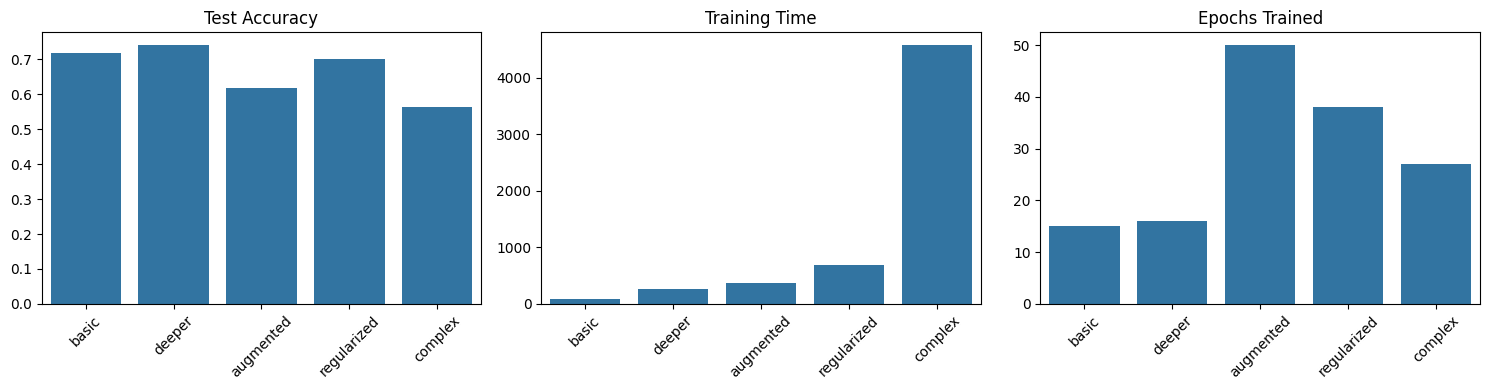

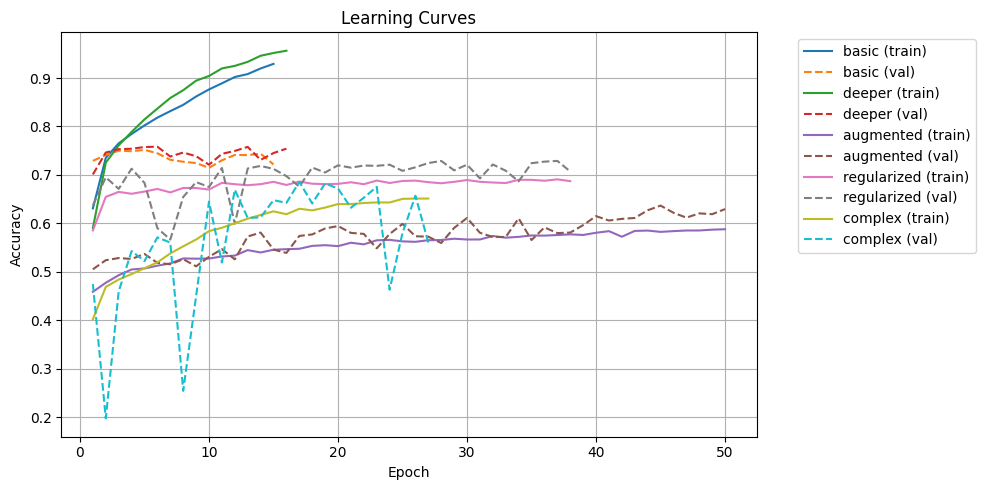


Model Performance Summary:
      Model Test Accuracy Training Time  Epochs                     Model Path
      basic        0.7174        95.24s      15       saved_models\basic.keras
     deeper        0.7404       260.17s      16      saved_models\deeper.keras
  augmented        0.6182       368.29s      50   saved_models\augmented.keras
regularized        0.7007       688.26s      38 saved_models\regularized.keras
    complex        0.5638      4576.81s      27     saved_models\complex.keras


In [8]:
from dataclasses import dataclass
from datetime import datetime
import os
from typing import Dict, List, Tuple

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Configuration class that defines our training parameters and model saving location
@dataclass
class TrainingConfig:
    batch_size: int = 20          
    epochs: int = 50               
    patience: int = 10               
    save_dir: str = 'saved_models'  


def train_model(model: tf.keras.Model, 
                config: TrainingConfig,
                train_data: Tuple,
                val_data: Tuple,
                test_data: Tuple,
                model_name: str) -> Dict:
    """Trains a single model and captures comprehensive metrics"""
    x_train, y_train = train_data
    x_val, y_val = val_data
    x_test, y_test = test_data
    
    # Check if model already exists
    save_path = os.path.join(config.save_dir, f"{model_name}.keras")
    if os.path.exists(save_path):
        print(f"Loading existing model: {model_name}")
        model = tf.keras.models.load_model(save_path)
        
        # Evaluate existing model
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        predictions = np.argmax(model.predict(x_test), axis=1)
        true_labels = np.argmax(y_test, axis=1)
        
        return {
            "history": {"accuracy": [test_accuracy], "val_accuracy": [test_accuracy]},
            "metrics": {
                "test_accuracy": test_accuracy,
                "test_loss": test_loss,
                "training_time": 0,
                "epochs_trained": 0
            },
            "classification_report": classification_report(true_labels, predictions, output_dict=True),
            "confusion_matrix": confusion_matrix(true_labels, predictions),
            "model_path": save_path
        }

    # Configure the model for training
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Set up early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=config.patience,
        verbose=1
    )

    # Train the model and measure training time
    start_time = datetime.now()
    history = model.fit(
        x_train, y_train,
        epochs=config.epochs,
        batch_size=config.batch_size,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping]
    )
    training_time = (datetime.now() - start_time).total_seconds()

    # Evaluate model performance
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    predictions = np.argmax(model.predict(x_test), axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Save the trained model
    os.makedirs(config.save_dir, exist_ok=True)
    model.save(save_path)
    
    # Return comprehensive training results
    return {
        "history": history.history,
        "metrics": {
            "test_accuracy": test_accuracy,
            "test_loss": test_loss,
            "training_time": training_time,
            "epochs_trained": len(history.history['accuracy'])
        },
        "classification_report": classification_report(true_labels, predictions, output_dict=True),
        "confusion_matrix": confusion_matrix(true_labels, predictions),
        "model_path": save_path
    }

def train_multiple_models(model_types: List[str],
                         training_config: TrainingConfig,
                         train_data: Tuple,
                         val_data: Tuple,
                         test_data: Tuple) -> Dict:
    """Trains multiple model architectures and collects their results"""
    results = {}
    for model_type in model_types:
        print(f"\nTraining {model_type} model...")
        model = create_model(model_type)
        results[model_type] = train_model(
            model, training_config, train_data, val_data, test_data, model_type
        )
    return results

def plot_training_comparison(results: Dict):
    """Creates a comparative visualization of model performance metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    metrics = ['test_accuracy', 'training_time', 'epochs_trained']
    
    for idx, metric in enumerate(metrics):
        values = [results[model]['metrics'][metric] for model in results.keys()]
        sns.barplot(x=list(results.keys()), y=values, ax=axes[idx])
        axes[idx].set_title(metric.replace('_', ' ').title())
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_learning_curves(results: Dict):
    """Visualizes learning curves for all trained models"""
    plt.figure(figsize=(10, 5))
    
    for model_name, data in results.items():
        history = data['history']
        epochs = range(1, len(history['accuracy']) + 1)
        
        plt.plot(epochs, history['accuracy'], label=f'{model_name} (train)')
        plt.plot(epochs, history['val_accuracy'], label=f'{model_name} (val)', 
                linestyle='--')
    
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_summary(results: Dict):
    """Prints a formatted summary of model performance"""
    summary_data = [{
        'Model': model_name,
        'Test Accuracy': f"{data['metrics']['test_accuracy']:.4f}",
        'Training Time': f"{data['metrics']['training_time']:.2f}s",
        'Epochs': data['metrics']['epochs_trained'],
        'Model Path': data['model_path']
    } for model_name, data in results.items()]
    
    print("\nModel Performance Summary:")
    print(pd.DataFrame(summary_data).to_string(index=False))

if __name__ == "__main__":
    # Example usage of the training framework
    config = TrainingConfig(save_dir='saved_models')
    
    # Select which model architectures to train
    model_types = ['basic', 'deeper', 'augmented', 'regularized', 'complex']
    
    # Convert one-hot encoded labels back to training, validation and test sets
    y_train = ethnicity_train
    y_val = ethnicity_val
    y_test = ethnicity_test
    
    # Train all selected models
    results = train_multiple_models(
        model_types,
        config,
        (x_train, y_train),
        (x_val, y_val),
        (x_test, y_test)
    )
    
    # Visualize and analyze results
    plot_training_comparison(results)
    plot_learning_curves(results)
    print_summary(results)

In [27]:
import requests
import os

def download_image(url, save_path='downloaded_image.jpg'):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise exception for bad status codes
        
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Image successfully downloaded to {save_path}")
        return save_path
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None

url = "https://ca-times.brightspotcdn.com/dims4/default/c3b977c/2147483647/strip/true/crop/2000x1405+0+0/resize/1200x843!/quality/75/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fc9%2Fa9%2F68435d41cf690e0c019e87278361%2F1f764b198a42470189b99b4084be6cf0"  
downloaded_file = download_image(url)

Image successfully downloaded to downloaded_image.jpg


In [28]:
import cv2
import numpy as np

def crop_face(image_path):
    # Read image
    img = cv2.imread(image_path)
    
    # Load face detection classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    if len(faces) > 0:
        # Get coordinates of first face
        x, y, w, h = faces[0]
        
        # Make square region
        center_x = x + w//2
        center_y = y + h//2
        size = max(w, h)
        
        # Calculate square coordinates
        x1 = max(0, center_x - size//2)
        y1 = max(0, center_y - size//2)
        x2 = min(img.shape[1], x1 + size)
        y2 = min(img.shape[0], y1 + size)
        
        # Crop face region
        face_square = img[y1:y2, x1:x2]
        
        return face_square
    return None

# Example usage:
image_path = 'downloaded_image.jpg'  # Use path from previous download
face_img = crop_face(image_path)
cv2.imwrite('face_only.jpg', face_img)


True

In [29]:
import tensorflow as tf
import numpy as np
import os

def load_models(model_dir):
    models = {}
    for name in os.listdir(model_dir):
        if name.endswith('.keras'):
            path = os.path.join(model_dir, name)
            model_name = name.replace('.keras', '')
            try:
                models[model_name] = tf.keras.models.load_model(path)
                print(f"Successfully loaded model: {model_name}")
            except Exception as e:
                print(f"Error loading model {model_name}: {str(e)}")
    return models

def process_image(image_path, target_size=(48, 48)):
    if isinstance(image_path, str):
        img = tf.keras.utils.load_img(image_path, target_size=target_size, color_mode='grayscale')
        img = tf.keras.utils.img_to_array(img)
    else:
        img = tf.image.resize(image_path, target_size)
    
    img = np.expand_dims(img, axis=0) / 255.0
    return img

def predict_image(image_path, models, class_names):
    processed_image = process_image(image_path)
    results = {}
    
    for name, model in models.items():
        pred = model.predict(processed_image, verbose=0)
        class_idx = np.argmax(pred[0])
        confidence = float(np.max(pred))
        
        results[name] = {
            'class': class_names[class_idx],
            'confidence': confidence
        }
    
    return results

def print_predictions(predictions):
    for model_name, pred in predictions.items():
        print(f"\n{model_name} model:")
        print(f"Predicted class: {pred['class']}")
        print(f"Confidence: {pred['confidence']:.2%}")


class_names = ['White', 'Black', 'Asian', 'Indian', 'Others']
models = load_models('saved_models')

image_path = 'face_only.jpg'
predictions = predict_image(image_path, models, class_names)
print_predictions(predictions)



Successfully loaded model: augmented
Successfully loaded model: basic
Successfully loaded model: complex
Successfully loaded model: deeper
Successfully loaded model: regularized

augmented model:
Predicted class: Black
Confidence: 98.88%

basic model:
Predicted class: White
Confidence: 96.41%

complex model:
Predicted class: Black
Confidence: 54.63%

deeper model:
Predicted class: White
Confidence: 52.51%

regularized model:
Predicted class: Black
Confidence: 53.63%
